<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>neural network architecture</a></span><ul class="toc-item"><li><span><a href="#training" data-toc-modified-id="training-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# tl;dr

In this notebook we will try to estimate the parameters of the **Burgers' equation** using a neural network. The equation is given by $$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

# setup

In [1]:
import pprint
import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

# data

<!-- **medidas** <br/> de [Lab 6: Simple Harmonic Oscillators](https://www.studocu.com/en-us/document/the-city-college-of-new-york/general-physics-i/lab-6-simple-harmonic-oscillators/27226380)

| $Time(s)$ | $Position (m)$ | $Velocity (m s^{-1})$ | Acceleration ($m s^{-2}$) |
|:-----------:|:---------------:|:-----------------:|:-----------------------:|
|      0      |     0.181104    |     -0.003521     |        0.0107877        |
|     0.5     |    0.1808296    |      -0.00048     |        -0.016009        |
|      1      |    0.1808296    |     0.0563435     |        0.9898961        |
|     1.5     |    0.2458624    |     0.0782269     |         1.068586        |
|      2      |     0.208544    |     -0.279888     |         0.698207        |
|     2.5     |    0.1808296    |     0.0872821     |        1.2009078        |
|      3      |     0.297724    |     0.0721215     |         -1.22394        |

Spring Constant: k = 16.16
Length of Spring: 0.18m
Length of Spring (Stretched): 0.787m
X= 0.607 

data = [
    [0, 0.181104, -0.003521, 0.0107877],
    [0.5, 0.1808296, -0.00048, -0.016009],
    [1, 0.1808296, 0.0563435, 0.9898961],
    [1.5, 0.2458624, 0.0782269, 1.068586],
    [2, 0.208544, -0.279888, 0.698207],
    [2.5, 0.1808296, 0.0872821, 1.2009078],
    [3, 0.297724, 0.0721215, -1.22394]
]

pd.DataFrame(data, columns=["t", "x", "v", "a"])
-->

**medidas** <br/> [Newton's Law of Cooling](https://qcpages.qc.cuny.edu/~zakeri/mat158/cooling.html)

$$ \frac{dT}{dt} = k (T-S) $$ 

where $k<0$ is a constant. 

$$ T=(T_0-S) e^{kt} + S \qquad \qquad  $$

where $T_0$ is the initial temperature.

,time,temperature
0,0,182.0
1,10,151.7
2,20,133.9
3,30,122.0
4,40,113.1
5,50,106.2
6,60,101.1
7,70,96.7
8,80,93.5
9,90,90.9


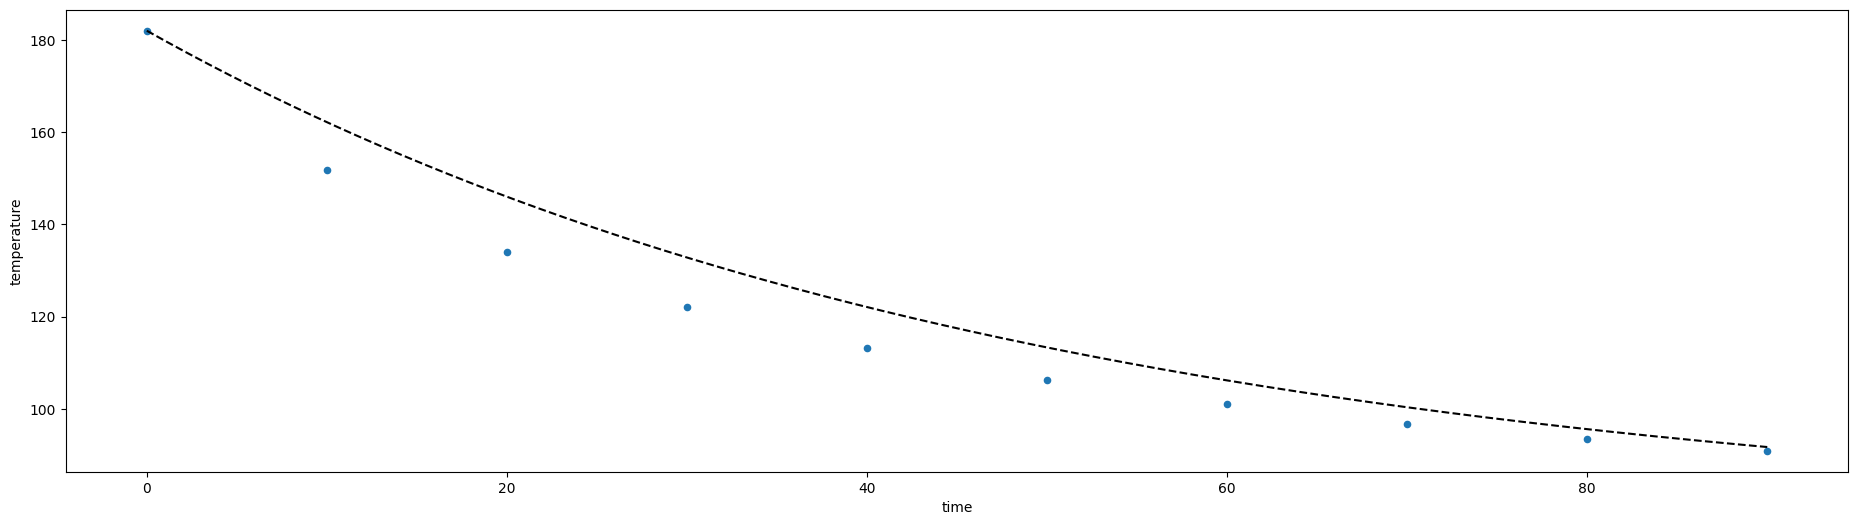

In [2]:
data = [
    [0,	10,	20,	30,	40,	50,	60,	70,	80,	90],
    [182.0,	151.7,	133.9,	122.0,	113.1,	106.2,	101.1,	96.7,	93.5,	90.9],
]
S = 74.6
k = -0.020416

X = pd.DataFrame(data).T.rename(columns={0: 'time', 1: 'temperature'}).astype({'time': int})

display(X)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.plot.scatter(x='time', y='temperature', ax=ax1)

t = np.linspace(0, 90, 1000)
T = (X['temperature'][0] - S) * np.exp(k * t) + S

ax1.plot(
    t,
    T, 
    c="k", linestyle="--",
    label="Theoretical model"
) ;

In [3]:
min_max_scaler = MinMaxScaler()

minmax_X = pd.DataFrame(min_max_scaler.fit_transform(X)).rename(columns={0: 'time', 1: 'temperature'})
minmax_S = min_max_scaler.transform([[0, S]])[0][1]

display(minmax_X)
print(minmax_S)

/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,time,temperature
0,0.000000,1.000000
1,0.111111,0.667398
2,0.222222,0.472009
3,0.333333,0.341383
4,0.444444,0.243688
5,0.555556,0.167947
6,0.666667,0.111965
7,0.777778,0.063666
8,0.888889,0.028540
9,1.000000,0.000000


-0.17892425905598264


In [4]:
train_test_threshold = 50

In [5]:
torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {train_test_threshold}")["temperature"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {train_test_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {train_test_threshold}")["temperature"].values).float().unsqueeze(1).to(device)

# neural network architecture

In [6]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;

In [10]:
hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 4,
    'n_neurons': 128,
    'num_epochs': 30000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

## training

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)


  0%|          | 0/30000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 1039/30000 [00:04<02:01, 238.22it/s]

Data Loss: 3.061508, Physics Loss: 826.609680, T0 Loss: 0.036078, Total Loss: 11.327966
k: 0.596568


  7%|▋         | 2042/30000 [00:07<01:59, 232.99it/s]

Data Loss: 0.263028, Physics Loss: 267.710632, T0 Loss: 0.000019, Total Loss: 2.940135
k: 0.251893


 10%|█         | 3041/30000 [00:12<01:55, 233.10it/s]

Data Loss: 0.114269, Physics Loss: 43.722679, T0 Loss: 0.000436, Total Loss: 0.551500
k: 0.002974


 13%|█▎        | 4040/30000 [00:15<01:44, 247.75it/s]

Data Loss: 0.113432, Physics Loss: 23.759533, T0 Loss: 0.000068, Total Loss: 0.351028
k: -0.054928


 17%|█▋        | 5044/30000 [00:19<01:40, 247.67it/s]

Data Loss: 0.100106, Physics Loss: 16.342922, T0 Loss: 0.000073, Total Loss: 0.263536
k: -0.052305


 20%|██        | 6044/30000 [00:22<01:02, 380.53it/s]

Data Loss: 0.180847, Physics Loss: 10.884025, T0 Loss: 0.001292, Total Loss: 0.289700
k: -0.046467


 23%|██▎       | 7041/30000 [00:26<01:06, 344.94it/s]

Data Loss: 1.862041, Physics Loss: 7.174317, T0 Loss: 0.002088, Total Loss: 1.933805
k: -0.042278


 27%|██▋       | 8033/30000 [00:28<01:08, 321.12it/s]

Data Loss: 1.279483, Physics Loss: 4.177167, T0 Loss: 0.026972, Total Loss: 1.321525
k: -0.037231


 30%|███       | 9039/30000 [00:32<01:27, 238.78it/s]

Data Loss: 0.160701, Physics Loss: 1.533015, T0 Loss: 0.007383, Total Loss: 0.176105
k: -0.030735


 33%|███▎      | 10048/30000 [00:37<01:22, 241.79it/s]

Data Loss: 3.998738, Physics Loss: 0.636531, T0 Loss: 0.000066, Total Loss: 4.005104
k: -0.024620


 37%|███▋      | 11059/30000 [00:40<01:06, 282.92it/s]

Data Loss: 0.008368, Physics Loss: 0.366028, T0 Loss: 0.000259, Total Loss: 0.012031
k: -0.023825


 40%|████      | 12034/30000 [00:44<01:01, 291.81it/s]

Data Loss: 0.000246, Physics Loss: 0.496960, T0 Loss: 0.000004, Total Loss: 0.005216
k: -0.023315


 43%|████▎     | 13037/30000 [00:48<01:11, 235.70it/s]

Data Loss: 0.003884, Physics Loss: 0.372548, T0 Loss: 0.000083, Total Loss: 0.007610
k: -0.023856


 47%|████▋     | 14048/30000 [00:51<00:50, 314.19it/s]

Data Loss: 0.091084, Physics Loss: 0.398638, T0 Loss: 0.002122, Total Loss: 0.095092
k: -0.022891


 50%|█████     | 15072/30000 [00:54<00:42, 350.49it/s]

Data Loss: 0.138845, Physics Loss: 0.284926, T0 Loss: 0.002602, Total Loss: 0.141720
k: -0.024818


 53%|█████▎    | 16045/30000 [00:58<00:59, 234.05it/s]

Data Loss: 0.016307, Physics Loss: 0.302829, T0 Loss: 0.000639, Total Loss: 0.019342
k: -0.024691


 57%|█████▋    | 17024/30000 [01:02<00:56, 231.05it/s]

Data Loss: 0.080685, Physics Loss: 0.278911, T0 Loss: 0.000683, Total Loss: 0.083481
k: -0.025126


 60%|██████    | 18039/30000 [01:06<00:50, 238.22it/s]

Data Loss: 0.198203, Physics Loss: 0.451906, T0 Loss: 0.006347, Total Loss: 0.202785
k: -0.026402


 64%|██████▎   | 19066/30000 [01:09<00:28, 381.25it/s]

Data Loss: 6.396593, Physics Loss: 0.280217, T0 Loss: 0.294666, Total Loss: 6.402341
k: -0.025226


 67%|██████▋   | 20037/30000 [01:13<00:39, 254.36it/s]

Data Loss: 0.006346, Physics Loss: 0.263433, T0 Loss: 0.000210, Total Loss: 0.008982
k: -0.025405


 70%|███████   | 21043/30000 [01:17<00:36, 246.68it/s]

Data Loss: 0.003401, Physics Loss: 0.234379, T0 Loss: 0.000130, Total Loss: 0.005746
k: -0.025287


 74%|███████▎  | 22066/30000 [01:20<00:20, 385.51it/s]

Data Loss: 0.144450, Physics Loss: 0.210990, T0 Loss: 0.006068, Total Loss: 0.146621
k: -0.025058


 77%|███████▋  | 23036/30000 [01:24<00:28, 244.72it/s]

Data Loss: 0.000041, Physics Loss: 0.232698, T0 Loss: 0.000000, Total Loss: 0.002368
k: -0.024828


 80%|████████  | 24059/30000 [01:27<00:16, 363.42it/s]

Data Loss: 0.000004, Physics Loss: 0.201320, T0 Loss: 0.000000, Total Loss: 0.002017
k: -0.024272


 84%|████████▎ | 25052/30000 [01:30<00:12, 411.81it/s]

Data Loss: 0.009076, Physics Loss: 0.200963, T0 Loss: 0.000045, Total Loss: 0.011086
k: -0.024271


 87%|████████▋ | 26030/30000 [01:32<00:10, 377.94it/s]

Data Loss: 0.000452, Physics Loss: 0.158227, T0 Loss: 0.000004, Total Loss: 0.002035
k: -0.024225


 90%|█████████ | 27066/30000 [01:36<00:08, 329.57it/s]

Data Loss: 5.570319, Physics Loss: 0.275098, T0 Loss: 0.363495, Total Loss: 5.576705
k: -0.024347


 93%|█████████▎| 28031/30000 [01:40<00:08, 236.92it/s]

Data Loss: 0.019212, Physics Loss: 0.223054, T0 Loss: 0.000364, Total Loss: 0.021446
k: -0.024815


 97%|█████████▋| 29073/30000 [01:43<00:02, 387.03it/s]

Data Loss: 0.005089, Physics Loss: 0.180399, T0 Loss: 0.000326, Total Loss: 0.006896
k: -0.024353


100%|██████████| 30000/30000 [01:46<00:00, 281.82it/s]

Data Loss: 0.000173, Physics Loss: 0.175365, T0 Loss: 0.000007, Total Loss: 0.001927
k: -0.023875


Text(0.5, 1.0, '$\\mathrm{Training}$ $\\mathrm{Loss}$')

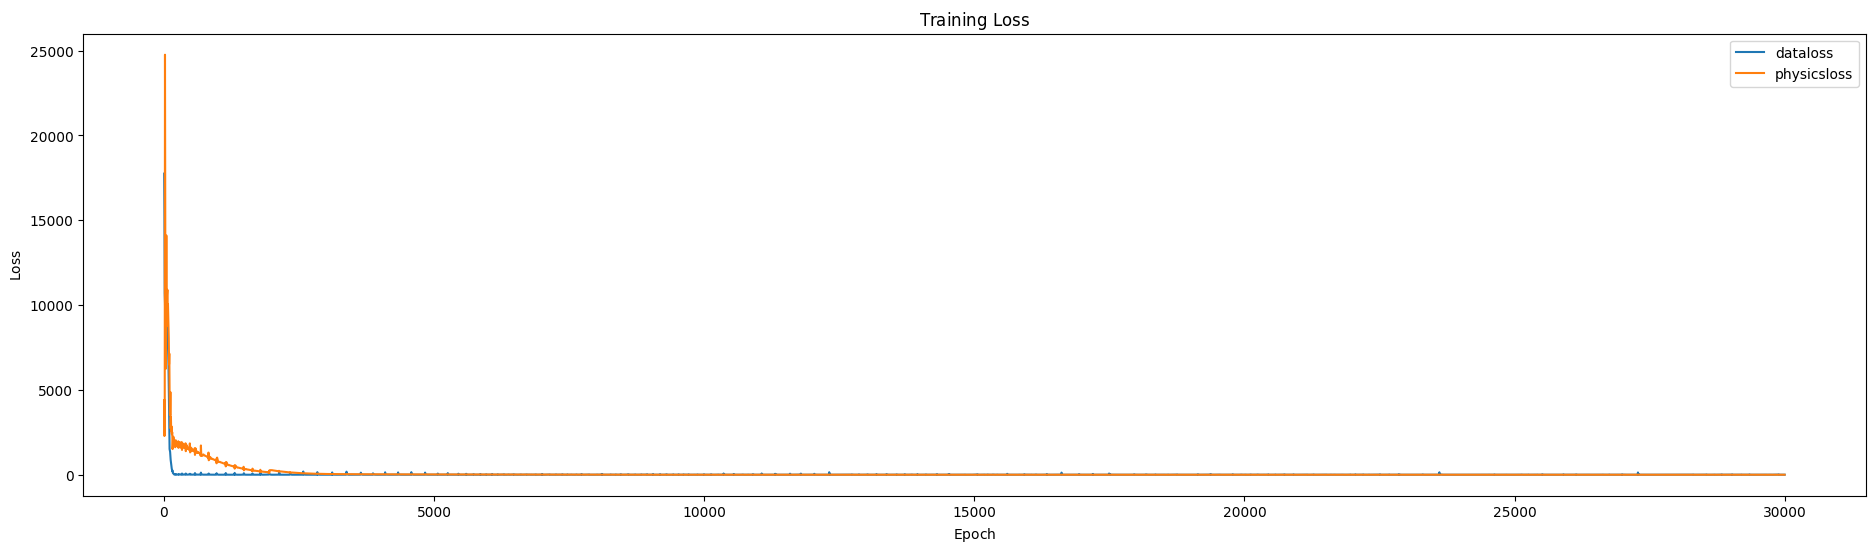

In [11]:
_locations = torch.linspace(0, 90, 45).view(-1,1).requires_grad_(True).to(device)
_S = torch.tensor(S, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(1.0, dtype=torch.float, requires_grad=True, device=device)
_T0 = torch.tensor(X["temperature"][0], dtype=torch.float, requires_grad=False).to(device)

model = MultiLayerPerceptronRegressor(architecture, nn.LeakyReLU)
model.to(device)
optimizer = optim.Adam([
    {"params": model.parameters()}, 
    {"params": [_k]}
], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]

    _diff_equation = dydt - _k * (y_location_hat - _S)

    physics_loss = torch.mean(_diff_equation**2)
    _T0_loss = criterion(y_location_hat[0], _T0)

    loss = data_loss + (1e-2)*(physics_loss + _T0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, T0 Loss: {_T0_loss.item():.6f}, Total Loss: {loss.item():.6f}")
        print(f"k: {_k.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

## results

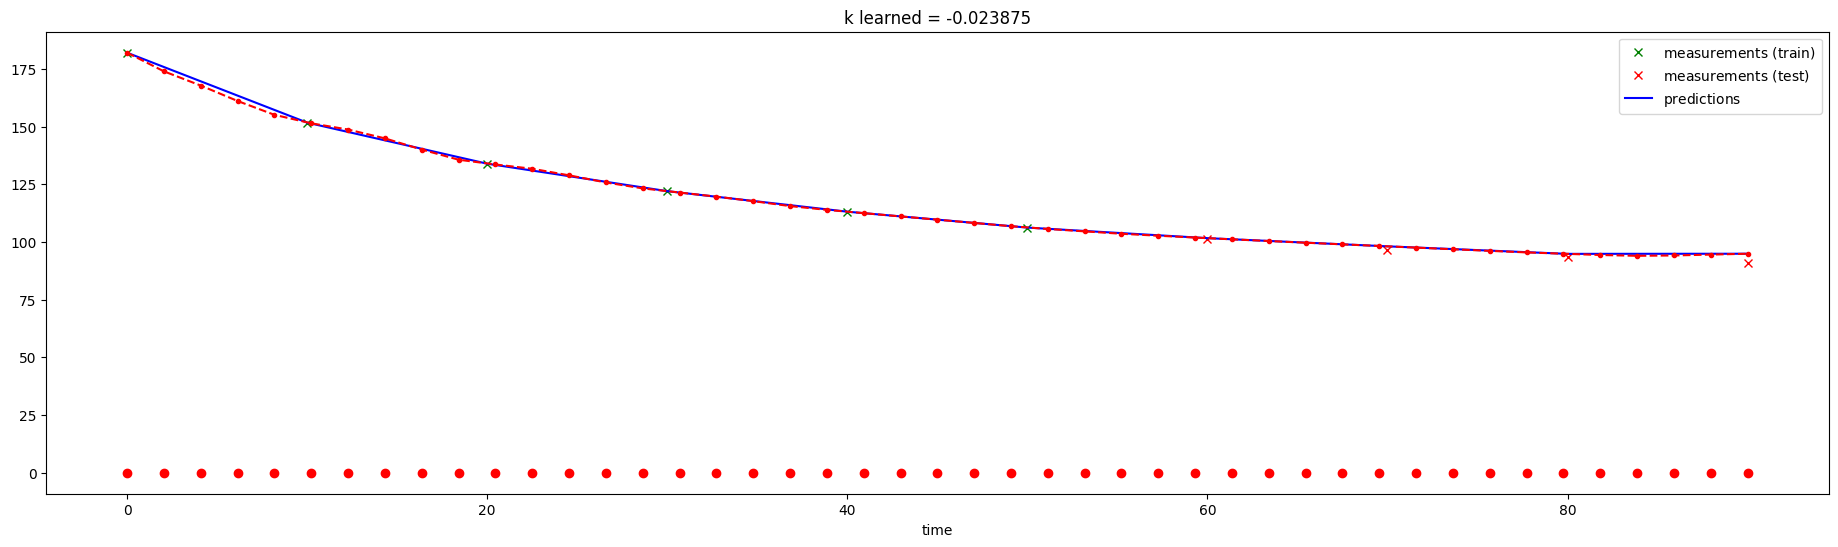

In [12]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query(f"time <= {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {train_test_threshold}").plot(
    x="time", 
    y="temperature", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) 

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
) 

plt.title(f"k learned = {_k.item():.6f}") ;

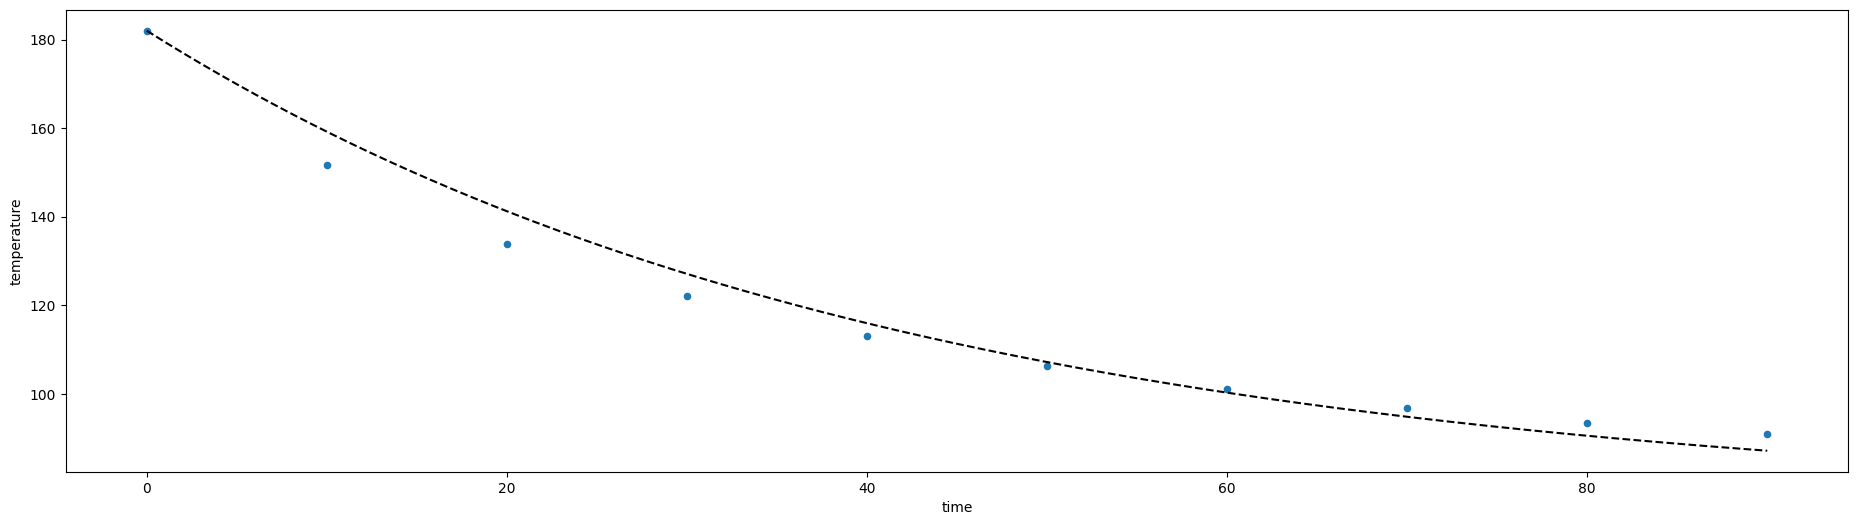

In [13]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.plot.scatter(x='time', y='temperature', ax=ax1)

t = np.linspace(0, 90, 1000)
T = (X['temperature'][0] - S) * np.exp(_k.item() * t) + S

ax1.plot(
    t,
    T, 
    c="k", linestyle="--",
    label="Theoretical model"
) ;

.